<a href="https://colab.research.google.com/github/mukthar56788/AI-Project/blob/main/Alarm_AnalysisV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving test1.xlsx to test1.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

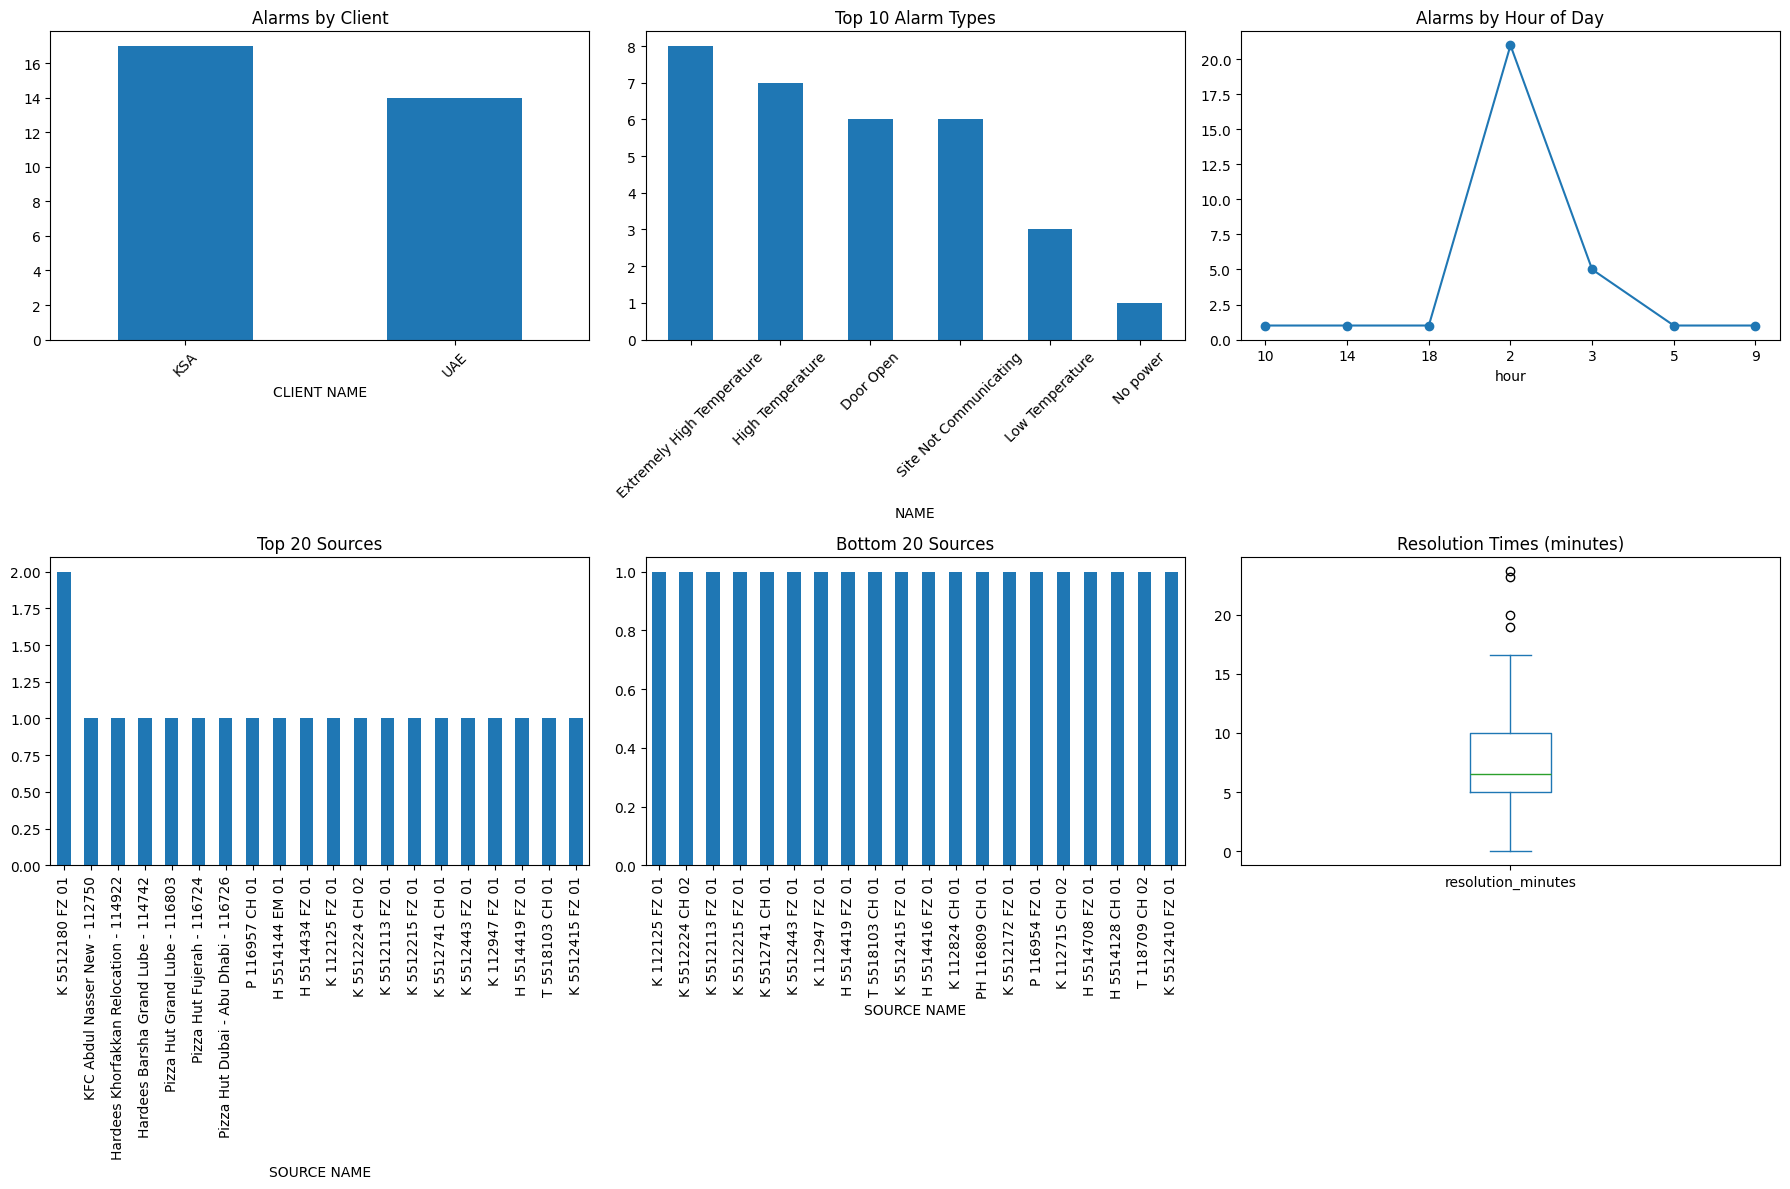

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
import json
from datetime import datetime
import numpy as np

# Custom JSON encoder
class CustomJSONEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, (np.integer)):
            return int(obj)
        if isinstance(obj, (np.floating)):
            return float(obj)
        if isinstance(obj, (datetime, pd.Timestamp)):
            return obj.isoformat()
        return super().default(obj)

# Upload and read file
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_excel(filename, header=3)

# Data cleaning
df['EVENT DAY'] = pd.to_datetime(df['EVENT DAY'], errors='coerce')
df['RESOLVED TIME'] = pd.to_datetime(df['RESOLVED TIME'], errors='coerce')
df['CLIENT NAME'] = df['CLIENT NAME'].replace({'americanauae': 'UAE', 'americanaksa': 'KSA'})
df['SOURCE NAME'] = df['SOURCE NAME'].str.strip()

# Calculate resolution time in minutes
df['resolution_minutes'] = (df['RESOLVED TIME'] - df['EVENT DAY']).dt.total_seconds() / 60
valid_resolutions = df.dropna(subset=['RESOLVED TIME'])
valid_resolutions = valid_resolutions[valid_resolutions['RESOLVED TIME'] >= valid_resolutions['EVENT DAY']]

# Initialize analysis results
analysis_results = {}

# 1-4. Basic alarm distributions
analysis_results['alarm_by_client'] = df['CLIENT NAME'].value_counts().to_dict()
if 'SOURCE TYPE NAME' in df.columns:
    analysis_results['alarm_by_source_type'] = df['SOURCE TYPE NAME'].value_counts().to_dict()
if 'GROUP' in df.columns:
    analysis_results['alarm_by_group'] = df['GROUP'].value_counts().to_dict()
analysis_results['alarm_by_name'] = df['NAME'].value_counts().to_dict()

# 5. Weekly and monthly trends with PATH
if 'SOURCE NAME' in df.columns and 'PATH' in df.columns:
    source_path_mapping = df.groupby('SOURCE NAME')['PATH'].agg(lambda x: x.mode()[0]).to_dict()

    # Weekly analysis
    weekly = (df.groupby(['SOURCE NAME', df['EVENT DAY'].dt.isocalendar().week.astype(str)])
              .size().unstack(fill_value=0))
    weekly = weekly.loc[(weekly > 0).any(axis=1)]
    weekly_dict = {}
    for source, week_data in weekly.to_dict('index').items():
        weekly_dict[source] = {
            'path': source_path_mapping.get(source, 'N/A'),
            'counts': {week: count for week, count in week_data.items() if count > 0}
        }
    analysis_results['alarm_by_source_weekly'] = weekly_dict

    # Monthly analysis
    monthly = (df.groupby(['SOURCE NAME', df['EVENT DAY'].dt.month_name().astype(str)])
               .size().unstack(fill_value=0))
    monthly = monthly.loc[(monthly > 0).any(axis=1)]
    monthly_dict = {}
    for source, month_data in monthly.to_dict('index').items():
        monthly_dict[source] = {
            'path': source_path_mapping.get(source, 'N/A'),
            'counts': {month: count for month, count in month_data.items() if count > 0}
        }
    analysis_results['alarm_by_source_monthly'] = monthly_dict

# 6. Hourly distribution
df['hour'] = df['EVENT DAY'].dt.hour.astype(str)
analysis_results['alarm_by_hour'] = df['hour'].value_counts().sort_index().to_dict()

# 7. Top/Bottom 20 sources with PATH
if 'SOURCE NAME' in df.columns and 'PATH' in df.columns:
    source_counts = df['SOURCE NAME'].value_counts()
    analysis_results['top20_sources'] = {
        source: {
            'count': int(count),
            'path': source_path_mapping.get(source, 'N/A')
        } for source, count in source_counts.head(20).items()
    }
    analysis_results['bottom20_sources'] = {
        source: {
            'count': int(count),
            'path': source_path_mapping.get(source, 'N/A')
        } for source, count in source_counts.tail(20).items()
    }

# 8. Resolution time stats
analysis_results['resolution_time_stats'] = valid_resolutions.groupby('NAME')['resolution_minutes'].agg(
    ['mean', 'median', 'count']).round(2).to_dict('index')

# 9. Highest and Lowest 20 resolution times with PATH
if 'SOURCE NAME' in df.columns and 'PATH' in df.columns:
    # Get top 20 longest resolutions
    top20_longest = valid_resolutions.nlargest(20, 'resolution_minutes')[['SOURCE NAME', 'PATH', 'resolution_minutes', 'EVENT DAY', 'RESOLVED TIME']]
    analysis_results['top20_longest_resolutions'] = [
        {
            'source': row['SOURCE NAME'],
            'path': row['PATH'],
            'time_minutes': round(row['resolution_minutes'], 2),
            'event_day': row['EVENT DAY'].isoformat(),
            'resolved_time': row['RESOLVED TIME'].isoformat()
        } for _, row in top20_longest.iterrows()
    ]

    # Get top 20 fastest resolutions
    top20_fastest = valid_resolutions.nsmallest(20, 'resolution_minutes')[['SOURCE NAME', 'PATH', 'resolution_minutes', 'EVENT DAY', 'RESOLVED TIME']]
    analysis_results['top20_fastest_resolutions'] = [
        {
            'source': row['SOURCE NAME'],
            'path': row['PATH'],
            'time_minutes': round(row['resolution_minutes'], 2),
            'event_day': row['EVENT DAY'].isoformat(),
            'resolved_time': row['RESOLVED TIME'].isoformat()
        } for _, row in top20_fastest.iterrows()
    ]

# Reorganize results with resolution extremes before temporal trends
final_results = {
    "summary": {
        "total_alarms": len(df),
        "resolved_alarms": len(valid_resolutions),
        "resolution_rate": round(len(valid_resolutions)/len(df)*100, 2),
        "time_period": {
            "start": df['EVENT DAY'].min().isoformat(),
            "end": df['EVENT DAY'].max().isoformat()
        }
    },
    "distributions": {
        "by_client": analysis_results['alarm_by_client'],
        "by_type": analysis_results.get('alarm_by_source_type', {}),
        "by_group": analysis_results.get('alarm_by_group', {}),
        "by_name": analysis_results['alarm_by_name'],
        "by_hour": analysis_results['alarm_by_hour']
    },
    "source_analysis": {
        "top_20": analysis_results.get('top20_sources', {}),
        "bottom_20": analysis_results.get('bottom20_sources', {})
    },
    "performance": {
        "resolution_times": analysis_results['resolution_time_stats'],
        "sla_compliance": {
            "within_15min": round((valid_resolutions['resolution_minutes'] <= 15).mean()*100, 2),
            "within_30min": round((valid_resolutions['resolution_minutes'] <= 30).mean()*100, 2),
            "within_1hour": round((valid_resolutions['resolution_minutes'] <= 60).mean()*100, 2)
        }
    },
    "resolution_extremes": {
        "longest_20_resolutions": analysis_results.get('top20_longest_resolutions', []),
        "fastest_20_resolutions": analysis_results.get('top20_fastest_resolutions', [])
    },
    "temporal_trends": {
        "weekly": analysis_results.get('alarm_by_source_weekly', {}),
        "monthly": analysis_results.get('alarm_by_source_monthly', {})
    }
}

# Save final organized results
with open('alarm_analysis_results.json', 'w') as f:
    json.dump(final_results, f, indent=2, cls=CustomJSONEncoder)

files.download('alarm_analysis_results.json')

# Generate visualizations
plt.figure(figsize=(18, 12))

# 1. Alarm by Client
plt.subplot(2, 3, 1)
df['CLIENT NAME'].value_counts().plot(kind='bar')
plt.title('Alarms by Client')
plt.xticks(rotation=45)

# 2. Alarm by Type
plt.subplot(2, 3, 2)
df['NAME'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Alarm Types')
plt.xticks(rotation=45)

# 3. Hourly Distribution
plt.subplot(2, 3, 3)
df['hour'].value_counts().sort_index().plot(kind='line', marker='o')
plt.title('Alarms by Hour of Day')

# 4. Top/Bottom 20 Sources
if 'SOURCE NAME' in df.columns:
    source_counts = df['SOURCE NAME'].value_counts()
    plt.subplot(2, 3, 4)
    source_counts.head(20).plot(kind='bar')
    plt.title('Top 20 Sources')
    plt.xticks(rotation=90)

    plt.subplot(2, 3, 5)
    source_counts.tail(20).plot(kind='bar')
    plt.title('Bottom 20 Sources')
    plt.xticks(rotation=90)

# 5. Resolution Times
plt.subplot(2, 3, 6)
valid_resolutions['resolution_minutes'].plot(kind='box')
plt.title('Resolution Times (minutes)')

plt.tight_layout()
plt.show()